In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch


=== Comparison of Linkage Methods ===


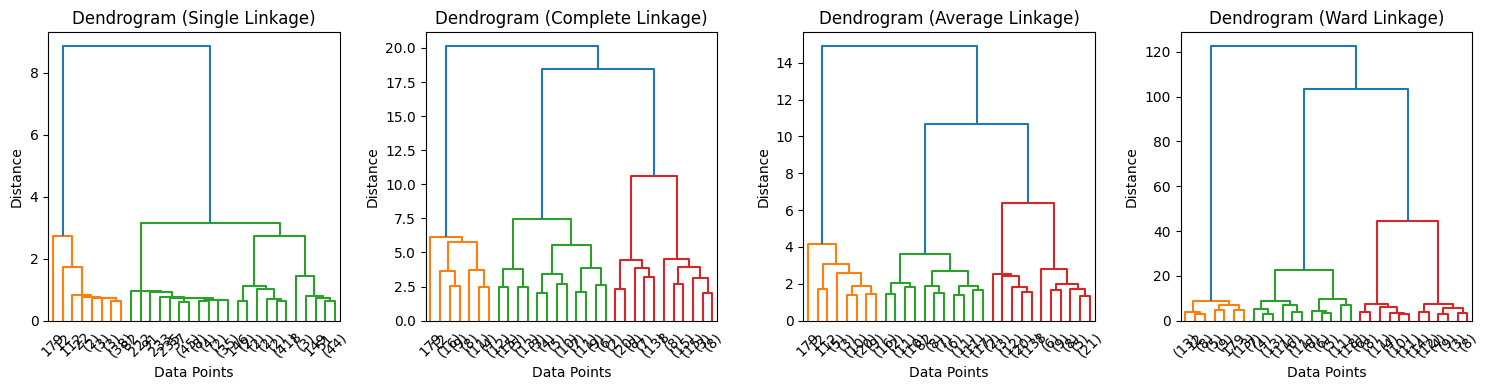

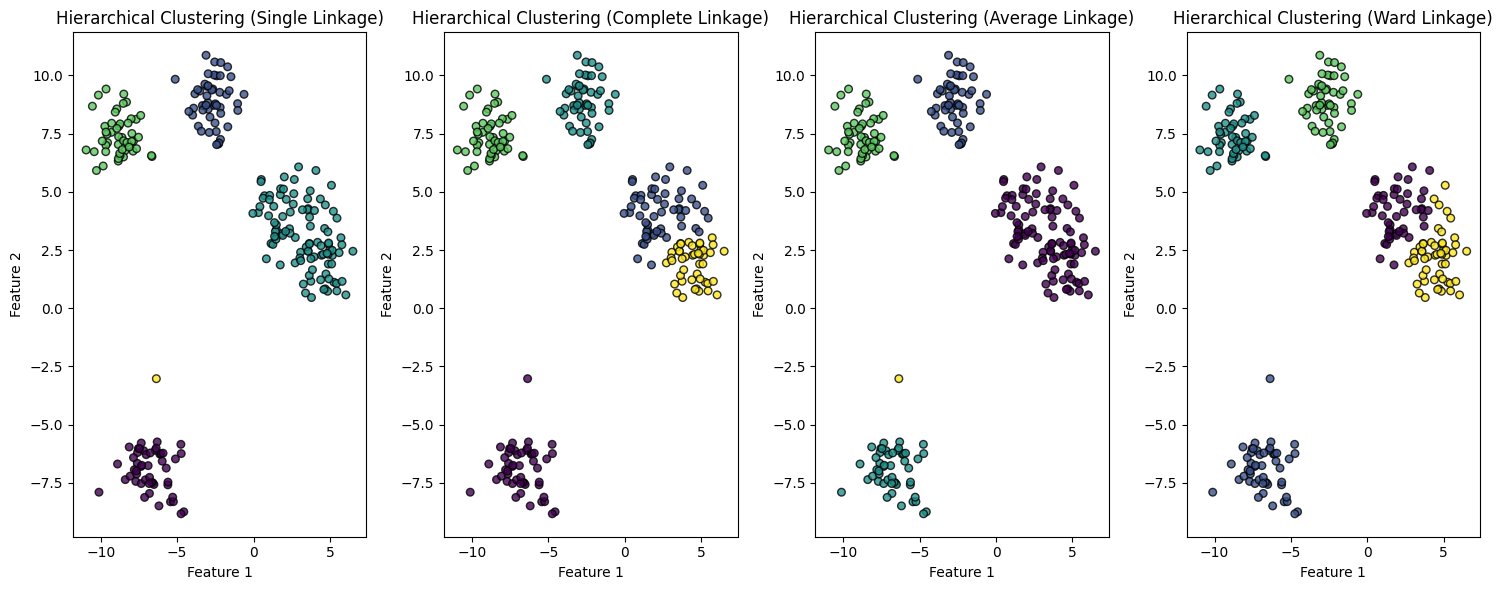

In [6]:
def compare_linkage_methods():
    # Generate dataset
    X, _ = make_blobs(n_samples=250, centers=5, cluster_std=1.0, random_state=42)
    
    # Define linkage methods to compare
    linkage_methods = ["single", "complete", "average", "ward"]
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    axes = axes.flatten()
    
    for idx, method in enumerate(linkage_methods):
        # Create linkage matrix
        Z = linkage(X, method=method)
        
        # Plot dendrogram
        axes[idx].set_title(f"Dendrogram ({method.capitalize()} Linkage)")
        dendrogram(Z, ax=axes[idx], truncate_mode='lastp', p=30, show_leaf_counts=True)
        axes[idx].set_xlabel("Data Points")
        axes[idx].set_ylabel("Distance")
    
    plt.tight_layout()
    plt.savefig("./figures/dendograms.png")
    plt.show()
    
    # Apply clustering with each method
    fig, axes = plt.subplots(1, 4, figsize=(15, 6))
    axes = axes.flatten()
    
    for idx, method in enumerate(linkage_methods):
        # For ward linkage, we need to use Euclidean distance
        if method == 'ward':
            hc = AgglomerativeClustering(n_clusters=5, linkage='ward', metric='euclidean')
        else:
            hc = AgglomerativeClustering(n_clusters=5, linkage=method)
        
        clusters = hc.fit_predict(X)
        
        axes[idx].scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', s=30, edgecolors='k', alpha=0.8)
        axes[idx].set_title(f"Hierarchical Clustering ({method.capitalize()} Linkage)")
        axes[idx].set_xlabel("Feature 1")
        axes[idx].set_ylabel("Feature 2")
    
    plt.tight_layout()
    plt.show()

print("\n=== Comparison of Linkage Methods ===")
compare_linkage_methods()


=== Customer Segmentation with Hierarchical Clustering ===


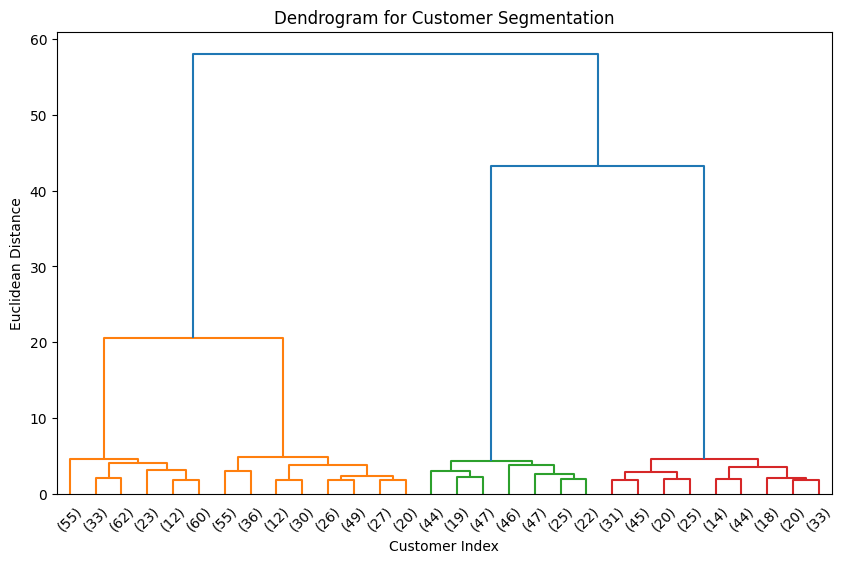

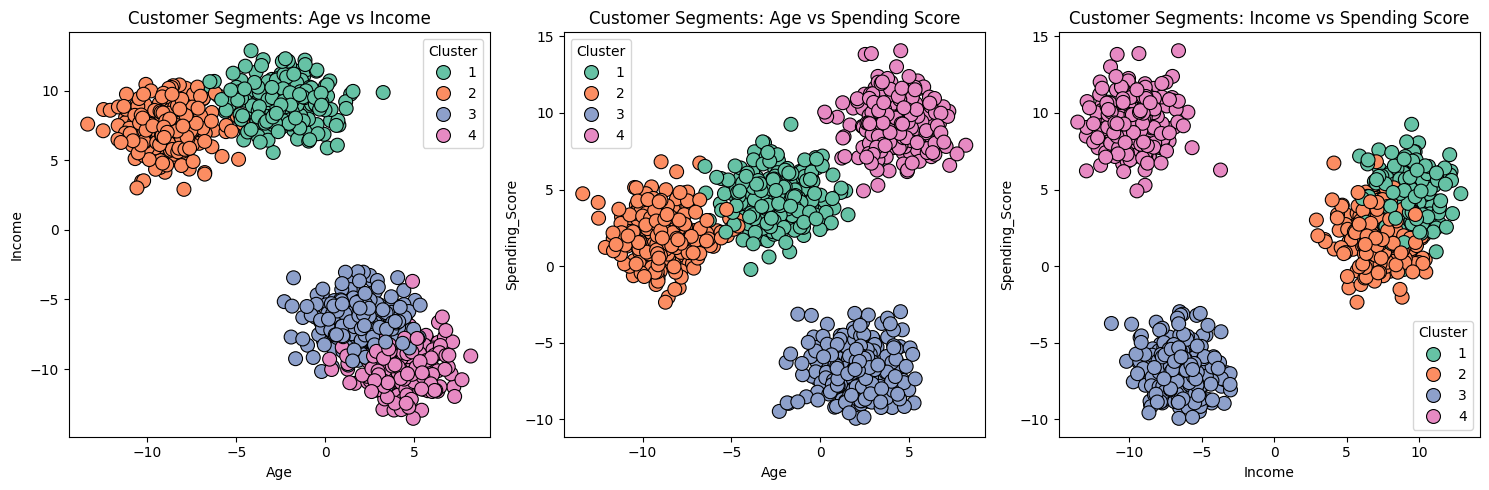


Cluster Summary (Centroids):
              Age    Income  Spending_Score
Cluster                                    
1       -2.414446  9.125507        4.445792
2       -8.812804  7.365958        2.076458
3        2.095691 -6.619834       -6.738867
4        4.315406 -9.655301        9.394982

Cluster Distribution:
Cluster
1    245
2    255
3    250
4    250
Name: count, dtype: int64


In [3]:
# ============ Customer Segmentation with HC ============
def customer_segmentation_hc():
    # Generate synthetic customer dataset
    np.random.seed(42)
    n_samples = 1000
    n_features = 3
    centers = 4
    
    X, _ = make_blobs(n_samples=n_samples, centers=centers, 
                      n_features=n_features, cluster_std=1.5, random_state=42)
    
    # Create DataFrame
    import pandas as pd
    df = pd.DataFrame(X, columns=['Age', 'Income', 'Spending_Score'])
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    # Apply Hierarchical Clustering
    Z = linkage(X_scaled, method='ward')
    
    # Plot dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(Z, truncate_mode='lastp', p=30, show_leaf_counts=True)
    plt.title('Dendrogram for Customer Segmentation')
    plt.xlabel('Customer Index')
    plt.ylabel('Euclidean Distance')
    plt.show()
    
    # Choose number of clusters (cut dendrogram at height that gives 4 clusters)
    clusters = fcluster(Z, t=4, criterion='maxclust')
    df['Cluster'] = clusters
    
    # Visualize clusters
    fig = plt.figure(figsize=(15, 5))
    
    # Age vs Income
    ax1 = fig.add_subplot(131)
    sns.scatterplot(data=df, x='Age', y='Income', hue='Cluster', palette='Set2', 
                    s=100, edgecolor='black', ax=ax1)
    ax1.set_title('Customer Segments: Age vs Income')
    
    # Age vs Spending Score
    ax2 = fig.add_subplot(132)
    sns.scatterplot(data=df, x='Age', y='Spending_Score', hue='Cluster', palette='Set2', 
                    s=100, edgecolor='black', ax=ax2)
    ax2.set_title('Customer Segments: Age vs Spending Score')
    
    # Income vs Spending Score
    ax3 = fig.add_subplot(133)
    sns.scatterplot(data=df, x='Income', y='Spending_Score', hue='Cluster', palette='Set2', 
                    s=100, edgecolor='black', ax=ax3)
    ax3.set_title('Customer Segments: Income vs Spending Score')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze cluster characteristics
    cluster_summary = df.groupby('Cluster').mean()
    print("\nCluster Summary (Centroids):")
    print(cluster_summary)
    
    cluster_distribution = df['Cluster'].value_counts().sort_index()
    print("\nCluster Distribution:")
    print(cluster_distribution)

print("\n=== Customer Segmentation with Hierarchical Clustering ===")
customer_segmentation_hc()


=== Biased-Randomized Ward's Method Demo ===


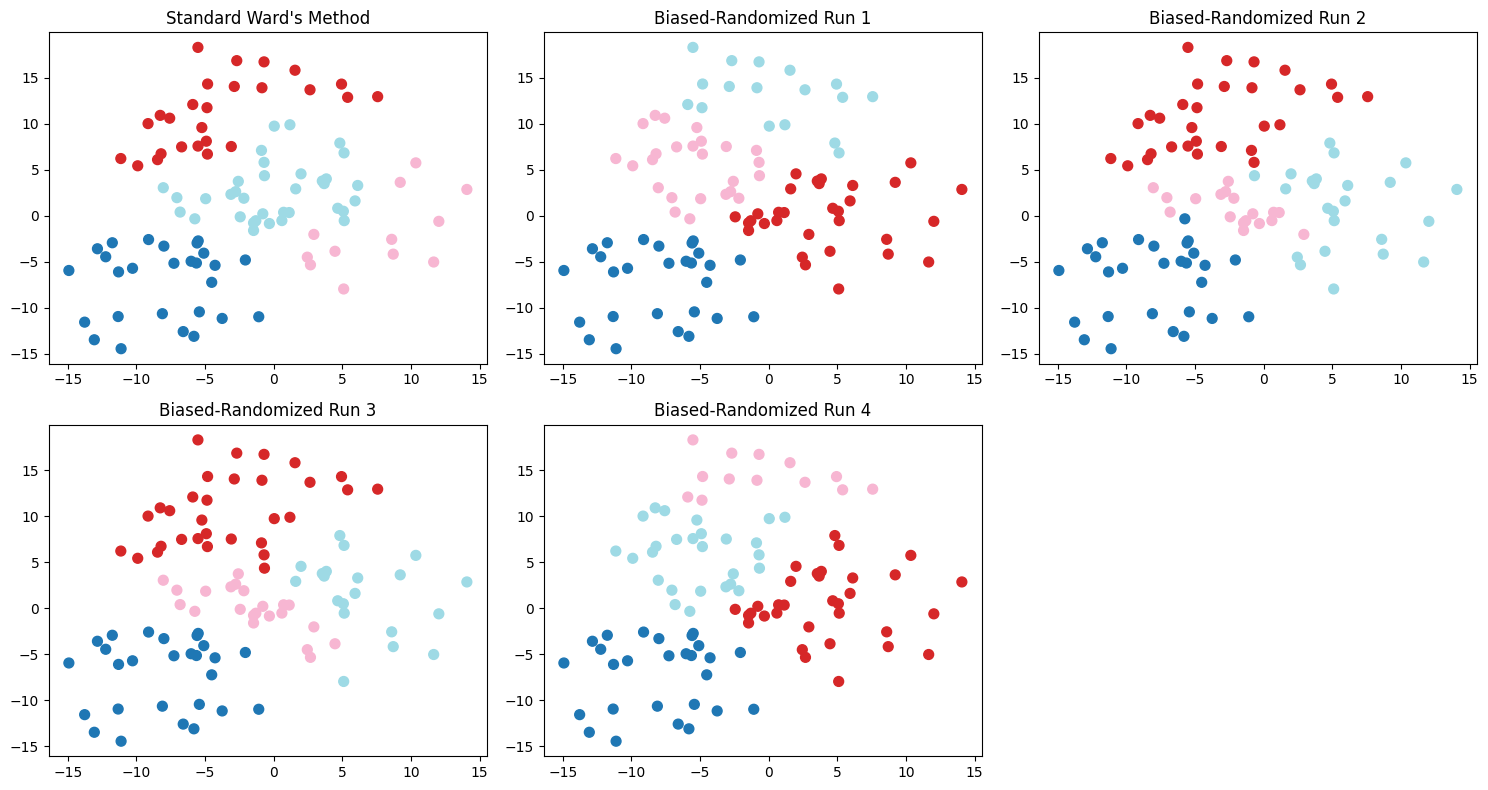


Comparing cluster assignments across runs:
Standard Ward's clusters distribution: [ 0 27 26 12 35]
Run 1 clusters distribution: [ 0 27 31 25 17]
Run 2 clusters distribution: [ 0 28 30 18 24]
Run 3 clusters distribution: [ 0 27 31 22 20]
Run 4 clusters distribution: [ 0 27 33 13 27]
Run 5 clusters distribution: [ 0 27 26 23 24]


In [4]:
def biased_randomized_ward_demo():
    # Generate synthetic data
    X, _ = make_blobs(n_samples=100, centers=3, cluster_std=5, random_state=42)
    
    # Standard Ward's clustering
    Z_standard = linkage(X, method='ward')
    labels_standard = fcluster(Z_standard, t=4, criterion='maxclust')
    
    # Simulate multiple runs with slight variations (simulating biased randomization)
    np.random.seed(42)
    results = []
    
    for run in range(5):
        # Add small noise to create variation
        X_noisy = X + np.random.normal(0, 0.5, X.shape)
        Z = linkage(X_noisy, method='ward')
        labels = fcluster(Z, t=4, criterion='maxclust')
        results.append(labels)
    
    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    # Standard Ward's
    axes[0].scatter(X[:, 0], X[:, 1], c=labels_standard, cmap='tab20', s=50)
    axes[0].set_title("Standard Ward's Method")
    
    # Biased-Randomized runs
    for i, labels in enumerate(results):
        axes[i+1].scatter(X[:, 0], X[:, 1], c=labels, cmap='tab20', s=50)
        axes[i+1].set_title(f'Biased-Randomized Run {i+1}')
    
    # Remove empty subplot
    fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    
    # Compare cluster assignments
    print("\nComparing cluster assignments across runs:")
    print("Standard Ward's clusters distribution:", np.bincount(labels_standard))
    for i, labels in enumerate(results):
        print(f"Run {i+1} clusters distribution:", np.bincount(labels))

print("\n=== Biased-Randomized Ward's Method Demo ===")
biased_randomized_ward_demo()